In [56]:
import json
import numpy as np
import os
import subprocess
import glob
from soma import aims, aimsalgo
import scipy
from scipy import ndimage
import seaborn as sns
import pandas as pd

from sulci.registration.spam import spam_register

import anatomist.api as ana
from soma.qt_gui.qtThread import QtThreadCall
from soma.qt_gui.qt_backend import Qt

from soma.aimsalgo import MorphoGreyLevel_S16

# Global static variables
_AIMS_BINARY_ONE = 32767
_threshold_for_spam = 10
_dilation = 5
_threshold = 0
_dilation_final = 5
_threshold_final = 0
_parallel = True

import matplotlib
from matplotlib import pyplot as plt

from p_tqdm import p_map

# launching anatomist
%matplotlib qt5
a = ana.Anatomist()




In [57]:
%matplotlib qt5

In [58]:
def dilate(mask, radius=_dilation):
    """Makes a dilation radius _dilation, in mm
    """
    arr = mask.np
    # Binarization of mask
    arr[arr < 1] = 0
    if radius > 0:
        arr[arr >= 1] = _AIMS_BINARY_ONE
        # Dilates initial volume of 10 mm
        morpho = MorphoGreyLevel_S16()
        dilate = morpho.doDilation(mask, radius)
        arr_dilate = dilate.np
        arr_dilate[arr_dilate >= 1] = 1
        return dilate
    else:
        arr[arr >= 1] = 1
        return mask

In [59]:
spam_file = '/neurospin/dico/data/deep_folding/current/mask/2mm/regions/L/Sc.Cal.-S.Li._left.nii.gz'
skel_path = '/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L'
skel_files = glob.glob(f'{skel_path}/*.nii.gz')
skel_files[:5]

['/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-5809266.nii.gz',
 '/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-4192947.nii.gz',
 '/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-1851213.nii.gz',
 '/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-1755382.nii.gz',
 '/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-1743426.nii.gz']

In [60]:
# Reads initial spam volume
spam_vol = aims.read(spam_file, dtype="Volume_FLOAT")
spam_vol.np[spam_vol.np < _threshold_for_spam] = 0

# Reads initial spam volume
spam_vol_untouched = aims.read(spam_file, dtype="Volume_FLOAT")

In [61]:
# Makes gaussian filter
# spam_vol_for_gaussian = aims.read(spam_file, dtype="Volume_FLOAT")
# spam_vol_for_gaussian.np[spam_vol_for_gaussian.np < _threshold_for_spam] = 0.
# spam_vol_for_gaussian.np[spam_vol_for_gaussian.np < _threshold_for_spam] = 1.
# g = aimsalgo.Gaussian3DSmoothing_FLOAT(10., 10., 10.)
# spam_vol_for_gaussian = g.doit(spam_vol_for_gaussian)
# spam_vol_for_gaussian.np[:] = spam_vol_for_gaussian.np / spam_vol_for_gaussian.max()

# # Applies filter to spam_vol
# spam_vol.np[:] = spam_vol.np * spam_vol_for_gaussian.np

In [62]:
print(np.unique(spam_vol.np))

[ 0. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34.]


In [63]:
def compute_bbox_mask(arr):

    # Gets location of bounding box as slices
    objects_in_image = ndimage.find_objects(arr)
    print(f"ndimage.find_objects(arr) = {objects_in_image}")
    if not objects_in_image:
        raise ValueError("There are only 0s in array!!!")

    loc = objects_in_image[0]
    bbmin = []
    bbmax = []

    for slicing in loc:
        bbmin.append(slicing.start)
        bbmax.append(slicing.stop)

    return np.array(bbmin), np.array(bbmax)

In [64]:
def copy_volume_info(vol, dtype='S16'):
    vol_copy = aims.Volume(vol.getSize(), dtype)
    vol_copy.copyHeaderFrom(vol.header())
    vol_copy.np[:] = 0 
    return vol_copy 

In [65]:
def do_masking_dilation(spam_vol, skel_vol, dilation, threshold, do_binarization):
   
    spam_vol = aims.Volume_FLOAT(spam_vol)
    skel_vol = aims.Volume_S16(skel_vol)
    
    # Do binarization for registration
    if do_binarization:
        skel_vol.np[:] = (skel_vol.np > 0).astype(np.int16)

    # Makes binarization and dilation on spam
    mask_result = copy_volume_info(spam_vol, 'S16')
    mask_result.np[:] = spam_vol.np
    
    # # Filter mask with Gaussian filter
    # arr_filter = scipy.ndimage.gaussian_filter(
    #     mask_result.np.astype(float),
    #     sigma=0.5,
    #     order=0,
    #     output=None,
    #     mode='reflect',
    #     truncate=4.0)
    # mask_result.np[:] = (arr_filter > 0.001).astype(int)
    
    # Threshold mask
    print("before threshold", np.unique(mask_result.np, return_counts=True)) 
    mask_result.np[mask_result.np <= threshold] = 0.
    
    # Dilates mask
    mask_result.np[:] = dilate(mask_result, dilation).np
    print("after threshold and dilation", np.unique(mask_result.np, return_counts=True))
    
    # Do the actual masking
    skel_vol.np[mask_result.np <= 0] = 0
    
    return skel_vol, mask_result

In [66]:
def realign(spam_vol: aims.Volume_FLOAT, skel_vol: aims.Volume_S16, sub_name: str):
    """Realigns skeleton mask to spam
    
    skel_f is a file name of skeleton file"""
    
    spam_vol = aims.Volume_FLOAT(spam_vol)
    skel_vol = aims.Volume_S16(skel_vol)
    
    # Masks with first dilation and threshold
    skel_vol_before, mask_dilated = do_masking_dilation(spam_vol_untouched, skel_vol, _dilation, _threshold, True)
    aims.write(skel_vol_before, f"/tmp/skel_before{sub_name}.nii.gz")
    print(np.unique(spam_vol.np))
    
    # Makes realignment
    out_tr = spam_register(spam_vol,
                        skel_vol_before,
                        do_mask=False,
                        R_angle_var=np.pi / 8,
                        t_var=5.,
                        verbose=False,
                        in_log=False,
                        calibrate_distrib=30)
    aims.write(out_tr, f'/tmp/transform{sub_name}.trm')
    print(out_tr.np)
    
    # Masks with final dilation and threshold
    skel_vol, spam_vol = do_masking_dilation(spam_vol_untouched, skel_vol, _dilation_final, _threshold_final, True)
    aims.write(skel_vol, f"/tmp/skel_final_before{sub_name}.nii.gz")
    aims.write(spam_vol, f"/tmp/spam_final_before{sub_name}.nii.gz")
    
    # Applies the realignment
    subprocess.check_call(f"AimsApplyTransform -i /tmp/skel_final_before{sub_name}.nii.gz -o /tmp/skel_final_realigned{sub_name}.nii.gz -m /tmp/transform{sub_name}.trm -t 0", shell=True)
    subprocess.check_call(f"AimsApplyTransform -i /tmp/spam_final_before{sub_name}.nii.gz -o /tmp/spam_final_realigned{sub_name}.nii.gz -m /tmp/transform{sub_name}.trm", shell=True)
    
    # loads realigned file:
    before = aims.read(f"/tmp/skel_final_before{sub_name}.nii.gz")
    after = aims.read(f"/tmp/skel_final_realigned{sub_name}.nii.gz")
    spam_after = aims.read(f"/tmp/spam_final_realigned{sub_name}.nii.gz")
    
    return before, after, spam_after, mask_dilated

In [67]:
before_all = copy_volume_info(spam_vol, 'S16')
after_all = copy_volume_info(spam_vol, 'S16')
list_after_cropped = []
subject_l = []
all_l = []

def realign_one_subject(skel_f):
    global before_all, after_all, spam_vol
    # Gets skeleton and subject name
    print(skel_f)
    sub_name = skel_f.split('_')[-1].split('.')[0]
    skel_vol = aims.read(skel_f)
    
    # Realign
    b, r, s, mask_dilated = realign(spam_vol, skel_vol, sub_name)
    
    # Gets volume before and after
    before = copy_volume_info(spam_vol, 'S16')
    before += b
    after = copy_volume_info(spam_vol, 'S16')
    after += r
    spam_after = copy_volume_info(spam_vol, 'S16')
    spam_after += s  
    
    # Crop volume to mask_dilated size
    bbmin, bbmax = compute_bbox_mask(mask_dilated)
    after_cropped = aims.VolumeView(after, bbmin, bbmax - bbmin)
    
    return (sub_name, after_cropped, before, after)

chosen_skel_files = skel_files[:60]

if _parallel:
    all_l = p_map(realign_one_subject, chosen_skel_files, num_cpus=46)
else:
    for skel_f in chosen_skel_files:
        all_l.append(realign_one_subject(skel_f))
    
for sub_name, after_cropped, before, after in all_l:
    subject_l.append(sub_name)
    list_after_cropped.append(after_cropped)
    # Adds volume to concatenate volume
    before_all += before
    after_all += after
    


  0%|          | 0/60 [00:00<?, ?it/s]

/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-5809266.nii.gz
/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-4192947.nii.gz/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-1851213.nii.gz
/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-1755382.nii.gz/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-1743426.nii.gz


/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-1702628.nii.gz/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-4497009.nii.gz/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-3089656.nii.gz

/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2m

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0   1   2   3   4   5   6   7   8   9  10 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0  11   1   2  12   3   4  13   5  14   6  15  16   7  17   8  18   9  19  10  20  11  21  12  13  22  14  23  15  24  16  25  17  26  18  19  27  20  28  21  29  22  30  23  31  24  32  25  33  26 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0  27  34   1  28  35   2  29   3  36  30   4  37  31   5  32  38   6  33 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 39 %Resampling carto_volume of S16...   0   7  34   1  40   8  35   2  41   9  36   3  10  42  37   4  11  12  38  43   5  13  14  39  44   6  15  16  40   7  45  17  18  41   8  46  19   9  42  47  20  10

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

Output voxel size: 2, 2, 2 mm
 55  29  18  51   1 %Resampling carto_volume of S16...   0 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
  1  30  19  56  52   2 %Resampling carto_volume of S16...   0  31   2  20   3  57  53 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
  1  32   3   4  21 %Resampling carto_volume of S16...   0  58  54   1  33  22   4   5   2  55  59  23  34  56  60   2   3  24  35   6   5  61   4  25  57  36  62  26  58  37  63  27   3 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
  5   6 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
  7  38 %Resampling carto_volume of S16...   0  64 %Resampling carto_volume of S16...   0  28   4   1   7   1  59  39  29   2   6  40  30  65   8   3  60   7  41  31   4   8   5   8   2  32  66  42   5  61   9 %loading direct transformations
Output dim

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

 36  46  31   9  51  14   5   5  39  33  42   7  22  38  90  54  82  40  46  27  12  37  47  10   6  32  15   6  34   8   6  41  43  23  39  83  91  55  47  28  52  13  11  16  48  38  33  42   7   7  35   9  44   7  43  24  40  84  48  56  29  92  53  14  17  12  49  39  34   8   8  10  45  36  44   8  25  41  85  49  57  30  18  15  93  13  54  50  40  35  46   9  45  11   9  37   9  50  26  86  42  31  19  58  46  16  14  94  12  47  36  41  51  55  10  10  10  38  51  87  27  43  32  47  20  13  59  17  15  48  37  52  95  42  11  39  11  11  52  88  56  48  33  28  44  14  21  60  40  16  18  49  12  53  38  43  96  12  12  49  53  89  57  34  41  29  22  45  15  61  17  50  19  13  54  39  44  13  13  97  50  90  54  42  35  30  16  58  23  46  62  51  18  14  20  51  55  40  14  45  14  91  98  55  43  36  17  24  31  47  59  63  52  19  52  15  21  92  56  15  41  46  15  99  56  44  37  18  25  32  48  53  60  53  64  20  93  16  22  57  16  47  42  16  38  45  57 100  19  26

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
somanifti warning: the data of the saved Nifti file will be loaded in a different in-memory order when opened by somanifti.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected v

 30 100  27  75  17  97  92  99  73  33   3  11 %
loading direct transformations
Output dimensions: 96, 114, 96
 50 %Output voxel size: 2, 2, 2 mm
 74  83  52   6  41  79  68  13  66  13  92  74 %Resampling carto_volume of S16...   0  31  18  76  28  98  93 100  74  34   4   1  51  69  12  53   7  84  75  42  67  14  14 %
 93  19  75  32  80  77  29  99  75  94   2  70  35   5  13  52   8  85  76  43  54  68 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 20 %loading direct transformations
Output dimensions: 96, 114, 96
 15 %Output voxel size: 2, 2, 2 mm
 33  15  94  76  76 100  81   3 %Resampling carto_volume of S16...   0  30 %Resampling carto_volume of S16...   0  71  95   6  78  36  53  69  14  77   9 %
 44  21  55   1   1  16  34  16  95  77   4  77  82  72  86  79  31  96   7  22  37  70  54  15  78  56  10   2  45   2  17   5  96  35  17  73  83  78  78  80  87  23   6  32  97  71   8  38  55   3  16  79  57  46  11   3  18  

somanifti warning: the data of the saved Nifti file will be loaded in a different in-memory order when opened by somanifti.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 33  62  74  34  83  75  62  76  42  77  63  63  84  35  78  43  64  79  80  64  85  44  81  65  36  65  82  37  66  45  83  86  67  66  46  38  84  68  87  69  39  85  67  88  47  86  70  40  48  87  68  69  71  41  49  88  89  72  90  42  50  70  43  89  73  44  51  45  71  91  52  46  74  53  90  47  75  54  48  76  92  55  72  49  77  56  78  50  57  91  51  79  58  93  59  73  80  52  60  92  94  53  81  74  93  95  75  94  61  96  76  95  97  77  96  62  98  78  82  97  54  79  99  98  80 100  63  83  99 %
 64  81  55 100  84  65 %
 82  66  85  83  56  67  86  84  68  69  57  87  70  85  88  71  86  58  72  89  90  87  73  91  59  74  75  92  60  76  88  93  94  61  77  95  62  78  96  63  79  89  97  64  80  98  65  81  99  90  66  82 100  67  83 %
 84  68  91  85  69  92  86  70  93  87  71  94  72  88  95  96  73  89  97  74  90  98  99  91  75 100 %
 76  92  77  93  78  94  79  80  95  81  82  96  83  97  84  98  85  99  86 100 %
 87  88  89  90  91  92  93  94  95 %

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 96  97  98  99 100 %
loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 37 %Resampling carto_volume of S16...   0   1   2  38   3  39   4   5  40   6  41   7  42   8  43   9  44  45  10  11  46  12  47  13  48  14  49  15  16  50  17  51  18  52  19  53  20  54  21  55  22  56  23  57  24  58  25  59  26  60  27  61  28  62  29  63  30  64  31  32  65  33  66  67  34  68  35  36  69  37  38  70  39  71  40  72  41  42  43  73  44  74  45  75  46  47  76  48  49  77  50  78  51  79  52  80  53  81  54  82  55  83  56  57  84  85  58  86  59  87  88  60  89  61  90  91  62  92  63  93  64  94  65  95  66  96  67  97  68  98  69  70  99  71 100  72 %
 73  74  75  76  77  78

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0   1 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0   1   2   2   3   3   4   4   5   5 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
  6 %Resampling carto_volume of S16...   0 %Resampling carto_volume of S16...   0   6   1   1   7   7   2   2   8   3   8   3   9   4   9   4  10   5   5  10  11   6   6  11  12   7   7  12  13   8   8  13  14   9   9  14  15  10  10  15  16  11  16  11  17  12  17  12 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 18 %loading direct transformations
Output dimensions: 96, 114, 96
loading direct transformations
Output dimensions: 96, 114, 96
loading direct trans

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

 26  23   4  37  18  21  26  35  19  13   3  14  24  42  17  11   5   5  42  24  38  23  19  27  22  15  27  14  20  36  12  43  25  18   4   6   6  39  43  20  25  16  24  23  28   7  13  28  26  15  44  37  19  21   7   5  17  40  21  44  26   8  25  14  24  27  29  29   8  16  20  38  45  22   6  18  22  41  45   9  15  27  25  26  28   9  21  30  30  17  46  39  23  19   7  42  23  16  10  46  26  29  28  10  27  22  20  31  31  18  40  47  24  43   8  24  17  11  27  30  47  11  21  29  23  28  32  19  32  41  48  25  44  25  18   9  28  12  31  12  22  48  24  30  29  33  20  33  42  26  19  49  45  26  29  13  10  23  13  32  25  49  31  30  21  20  34  34  43  27  27  50  46  30  24  14  14  33  11  26  50  32  21  31 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 25  35  22  15  31  28  44  47  35  28  51  15 %Resampling carto_volume of S16...   0  34  12  27   1  51  22  26  33  16  32  32  29  36  23  48  16  45  36  29  52  3

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"




ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-4612520.nii.gz


ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]

ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 7

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
somanifti warning: the data of the saved Nifti file will be loaded in a different in-memory order when opened by somanifti.
somanifti warning: the data of the saved Nifti file will be loaded in a different in-memory order when opened by somanifti.


ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-5259223.nii.gz
before thresholdbefore thresholdndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))] 
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int16), array([1044188,    1621,     878,     566,     428,     366,     300,
           287,     257,     218,     183,     201,     169,     156,
           149,     123,      95,      91,      89,      52,      45,
            30,      32,      15,      18,      14,      13,       9,
             9,       6,       6,       4,       2,       2,       2]))
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None),

  2%|▏         | 1/60 [00:09<09:08,  9.30s/it]

after threshold and dilation 
(array([0, 1], dtype=int16), array([1036637,   13987]))before threshold ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int16), array([1044188,    1621,     878,     566,     428,     366,     300,
           287,     257,     218,     183,     201,     169,     156,
           149,     123,      95,      91,      89,      52,      45,
            30,      32,      15,      18,      14,      13,       9,
             9,       6,       6,       4,       2,       2,       2]))
/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/skeletons/2mm/L/Lresampled_skeleton_sub-2681846.nii.gz
after threshold and dilation (array([0, 1], dtype=int16), array([1036637,   13987]))
before threshold (array([ 0,  1,  2,  3,  4,  5,  6,  

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
  3%|▎         | 2/60 [00:09<03:47,  3.92s/it]

[ 0. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26.
 27. 28. 29. 30. 31. 32. 33. 34.]
after threshold and dilatio 25  51  89  46  74 100  76  52  47 %
 77  75  90  26  53  48  78  54  76  49  79  91  55  27  77  80  50  56  92  78  81  51  57  28  79  82  52  93  58  80  83  53  29  81  94  84  54  59  85  82  95  60  30  55  86  83  61  96  56  87  84  62  31  57  88  97  63  85  58  89  64  86  32  98  59  90  65  87  91  60  66  99  88  33  92  61  67 100  89 %
 93  62  68  34  94  90  69  63  95  91 %DILATION
 96  35  92  70  64  97  93  98  71  36  94  65  99  95  72 100  66  37  96 %
 97  73 %DILATION
 67  98  38  99  74  68 100  39 %
 75  69  40  76  70  41  77  78  71  42 %DILATION
 79  72  43  80  44  73  81  45  74  82  46  75  83  84  47  76  85  86  48  87  77  88  49  89  78  90  50  91  79  92  51 %DILATION
 93  80  94  52 %DILATION
 95  81  96  53  97  82  98  54  99  83  55 100 %
 84  56  57  85  58  86  59  87 %DILATION
 60  88  61  89  

  7%|▋         | 4/60 [00:10<01:37,  1.74s/it]

[[ 1.0000000e+00  2.2924196e-08 -4.9880657e-07  5.3405762e-05]
 [-2.2925956e-08  1.0000000e+00 -3.5279986e-06  4.1198730e-04]
 [ 4.9880651e-07  3.5279986e-06  1.0000000e+00 -7.0190430e-04]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
DILATION
DILATION
DILATION
DILATION
DILATION
before threshold (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34], dtype=int16), array([1044188,    1621,     878,     566,     428,     366,     300,
           287,     257,     218,     183,     201,     169,     156,
           149,     123,      95,      91,      89,      52,      45,
            30,      32,      15,      18,      14,      13,       9,
             9,       6,       6,       4,       2,       2,       2]))
after threshold and dilation (array([0, 1], dtype=int16), array([1036637,   13987]))
[[ 9.8667920e-01 -1.0641718e-03 -1.6267464e-01  1.9835861e+01]
 [-2.496

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 32 %Resampling carto_volume of S16...   0  33   1  34   2  35   3  36   4  37   5  38   6  39   7  40   8  41   9  42  10  43  11  44  12  45  13  46  14  47  15  48  16  49  17  50  18  51  19  52  20  53  21  54  22  55  23  56  24  57  25  58  26  59  27  60  28  61  29  62  30  63  64  31  65  32  66  33  67  34  68  35  69  36  70  37  71  38  72  39  73  74  40  75  41  76  42  77  43  78  44  79  45  80  46  81  47  82  48  83  49  84  50  85  51  86  52  87  53  88  54  89  55  90  56  91  57  92  58  93  94  59  95  60  96  61  97  62  98  63  64  99  65 100 %
 66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  8

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 87  88  89  90 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 91 %Resampling carto_volume of S16...   0  92   1  93  94   2  95  96   3  97  98   4  99 100 %
  5   6   7   8   9  10  11 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 12 %Resampling carto_volume of S16...   0   1   2  13   3   4  14   5   6  15   7   8  16   9  10  17  11  12  13  18 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 14 %Resampling carto_volume of S16...   0  15   1  19  16   2  17   3  18  20   4  19   5  20   6  21  21   7  22   8  23  22   9  24  10  25  11  23  26  12  27  13  24  28  14  29  25  15  30  16  26  31  17  32  27  18  33  19  28  34  20  29  35  21  30  36  22  37  31  23  38  32  24  39  33  25  40  34 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 26  41  35 %Resampling carto_volume of S16...   0 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

  5  13  65 %
 91   6  14  66  92   7  15  67  93   8  16  94  68   9  17  69  95  10  18  70  96  11  19  97  71  12  20  98  72  13  99  21  73  14 100  74  22 %
 15  75  23  16  76  24  17  77  25  18  78  26  19  79  27  20  80  28  21  81  29  22  82  23  30  83 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 24  31  84 %Resampling carto_volume of S16...   0  25   1  32 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 85  26   2 %Resampling carto_volume of S16...   0  33  86   1  27   3  34  87   2  28   4  88  35   3  29   5  89   4  36  30   6  90   5  37  31   7  91   6  32  38   8  92   7  33  39   9  93   8  34  40  10  94   9  35  41  11  95  10  36  12  42  96  11  37  13  97  43  12  38  14  98  13  44  39  15  99  14  45  40  16  15 100  41  46 %
 17  16  42  47  18  17  43  48  18  19  44  49  19  20  45  50  20  21  46  51  21  22  47  52  22  23  48  53  24  23  49  54  24 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
somanifti warning: the data of the saved Nifti file will be loaded in a different in-memory order when opened by somanifti.


 19  92  93  20  94  95  21  96  97  22  98  99  23 100 %
 24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 %


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30 %

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 31  32  33  34  35  36  37  38  39  40  41  42  43  44  45 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
Resampling carto_volume of S16...   0  46   1  47   2  48   3  49   4  50   5  51   6  52   7   8  53   9  54  10  55  11  56  12  57  13  58  14  59  15  60  16  61  17  62  18  63  19  64  20  21  65  22  66  23  67  24  68  25  69  26  70  27  71  28  72 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 29 %Resampling carto_volume of S16...   0  73   1  30  74   2  31  75   3  32  76   4  33  77   5  34  78   6  35  79   7  36  80   8  37  81   9  38  82  10  39  83  11  40  84  12  41  85  13  42  86  14  43  87  15  44  88  16  45  89  17  46  90  18  47  91 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 19  48  92 %Resampling carto_volume of S16...   0   1  20  49  93   2  50  21   3  94   4  51  22  95   5  52  23  96   6  53  24  97   

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
 11 %
 57  28  12  58  29  13  59  30  14  60  31  15  61  32  16  62  33  17  63  34  18 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 64  19  35 %Resampling carto_volume of S16...   0   1  65  20  36   2  66  21  37   3  67  22   4  38   5  68  23 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 39 %Resampling carto_volume of S16...   0   6   1  69  24  40   7   2  25  70   8  41   3   9  26  71  42   4  10  27  72   5  43  11   6  28  73  44  12   7  29  74  45  13   8  30  75  14  46   9  31  76  15  47  10  16  32  77  48  11  17  33  78  12  49  18  34  79  13  50  19  35  80  14  51  20  81  36  15  21  52  37  82  22  16  53  83  38  23  17  54  24  84  39  1

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
 78%|███████▊  | 47/60 [00:13<00:01,  6.50it/s]

ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
 79   5  84  23  99   6  80 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 85 100  24  37 %Resampling carto_volume of S16...   0   7  81 %
  1 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 86  25   8  82 %Resampling carto_volume of S16...   0  38   2  87  26   1   9  83   3  88  39  27  10   2  84   4  89  28  11   3  40  85   5  29  90  12   4  41  86   6  30  13  91   5  42  87   7  31  14   6  92  43  88   8  32  15   7  44  93  89   9  33  16  45  94   8  90  10  34  17  46  95   9  91  11  35  47  18  96  10  92  12  36  48  19  97  11  93  13  37  49  20  98  94  12  14  50  38  21  99  95  13  15  51  39  22 100  96 %
 14  16  52  40  23  97  17  15  53  41

somanifti warning: the data of the saved Nifti file will be loaded in a different in-memory order when opened by somanifti.


ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]


 80%|████████  | 48/60 [00:13<00:01,  6.38it/s]

ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
 67  87  59  86  94  68  88  60  87  95  69  89  61  88  96  70  90  62  97  89  71  91  63  98  90  72  92  64  99  91  73  93 100  65  92 %
 74  94  66  93  95  75  67  94  96  76  68  95  97  77  69  96  98  78  70  97  99  79  71  98 100  80  72 %
 99  73  81 100 %
 74  82  75  83  76  84  77  85  78  86  79  87  80 %loading direct transformations
Output dimensions: 96, 114, 96
Output voxel size: 2, 2, 2 mm
 88  81 %R

 82%|████████▏ | 49/60 [00:13<00:01,  6.45it/s]

ndimage.find_objects(arr) = [(slice(43, 68, None), slice(63, 105, None), slice(40, 76, None), slice(0, 1, None))]
 67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 %


100%|██████████| 60/60 [00:13<00:00,  4.29it/s]


In [68]:
subject_l

['sub-5809266',
 'sub-4192947',
 'sub-1851213',
 'sub-1755382',
 'sub-1743426',
 'sub-1702628',
 'sub-4497009',
 'sub-3089656',
 'sub-4784773',
 'sub-1768672',
 'sub-4429017',
 'sub-2313010',
 'sub-5906677',
 'sub-2323853',
 'sub-2429755',
 'sub-2242301',
 'sub-1037052',
 'sub-5603035',
 'sub-4707694',
 'sub-5023079',
 'sub-3427351',
 'sub-4730906',
 'sub-5665066',
 'sub-3415482',
 'sub-5645677',
 'sub-3505608',
 'sub-2863115',
 'sub-4323239',
 'sub-3220768',
 'sub-4372801',
 'sub-1482435',
 'sub-3314499',
 'sub-3947659',
 'sub-5769817',
 'sub-2271266',
 'sub-3542303',
 'sub-1876468',
 'sub-1508718',
 'sub-3001704',
 'sub-1817988',
 'sub-4818279',
 'sub-3956683',
 'sub-3151402',
 'sub-3384046',
 'sub-1743604',
 'sub-2552580',
 'sub-2239593',
 'sub-4612520',
 'sub-2790182',
 'sub-3988338',
 'sub-2909445',
 'sub-2700332',
 'sub-3490710',
 'sub-5259223',
 'sub-1201951',
 'sub-1465471',
 'sub-4322807',
 'sub-3043018',
 'sub-2681846',
 'sub-1357127']

In [69]:
len(list_after_cropped)

60

In [70]:
len(skel_files)

21051

In [71]:
# spam_before = aims.read("/tmp/spam_final_before.nii.gz")
# bbmin, bbmax = compute_bbox_mask(spam_before.np)
# before_cropped = aims.VolumeView(spam_before, bbmin, bbmax - bbmin)
# before_cropped.shape

In [72]:
np.unique(before_all.np)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35], dtype=int16)

In [73]:
np.unique(after_all.np)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 35],
      dtype=int16)

In [74]:
diff_all = after_all - before_all

In [75]:
np.unique(diff_all.np)

array([-24, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11,
       -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19], dtype=int16)

In [76]:
# Reads initial spam volume
spam_vol = aims.read(spam_file, dtype="Volume_FLOAT")
# spam_vol.np[spam_vol.np < _threshold_for_spam] = 0


In [77]:
# Visualization
spam = a.toAObject(spam_vol)
before_a = a.toAObject(before_all)
diff_a = a.toAObject(diff_all)
before_a.setPalette("Blues")
diff_a.setPalette("bwr")
# spam_before = a.toAObject(before_all)
# spam_before.setPalette("Blues")
# spam_after = a.toAObject(after_all)Utilities to generate foldlabels from graph
# spam_after.setPalette("Reds")
w = a.createWindow('Sagittal')
w.addObjects(spam)
# w.addObjects(before_a)
w.addObjects(diff_a)
# w.addObjects(spam_before)
# w.addObjects(spam_after)

crop_a = a.toAObject(after_cropped)
w_crop = a.createWindow('Sagittal')
w_crop.addObjects(crop_a)


observable 0x61bb6655bc10(N9anatomist7AVolumeIsEE) could not be removed from observer 0x61bb6a590908 (N9anatomist8Fusion2DE)


In [78]:
# spam = a.loadObject(spam_file)
# spam.setPalette("Blues")
# list_after_a = [a.toAObject(after) for after in list_after]
# for after in list_after_a:
#     after.setPalette("RED-lfusion")
# w = a.createWindow('Sagittal')
# w.addObjects(list_after_a)
# w.addObjects(spam)

In [79]:
for l in list_after_cropped:
    print(l.shape)

(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)
(25, 42, 36, 1)


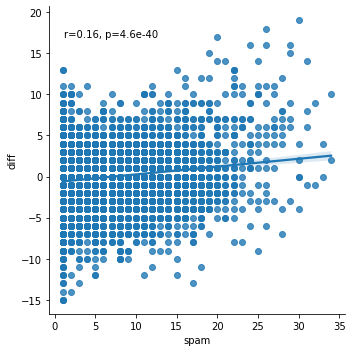

In [80]:
%matplotlib inline
# Reads initial spam volume
spam_vol = aims.read(spam_file, dtype="Volume_FLOAT")

df_dict = {"spam": spam_vol.np[spam_vol.np>0].flatten(),
           "diff": diff_all.np[spam_vol.np>0].flatten()}
df = pd.DataFrame(df_dict)
g = sns.lmplot(data=df, x="spam", y="diff")

def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['spam'], data['diff'])
    ax = plt.gca()
    ax.text(.05, .9, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

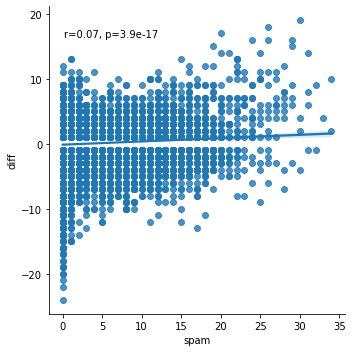

In [81]:
%matplotlib inline
# Reads initial spam volume
spam_vol = aims.read(spam_file, dtype="Volume_FLOAT")

df_dict = {"spam": spam_vol.np[diff_all.np!=0].flatten(),
           "diff": diff_all.np[diff_all.np!=0].flatten()}
df = pd.DataFrame(df_dict)
g = sns.lmplot(data=df, x="spam", y="diff")

def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['spam'], data['diff'])
    ax = plt.gca()
    ax.text(.05, .9, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

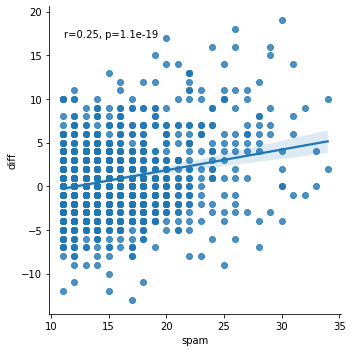

In [82]:
%matplotlib inline
# Reads initial spam volume
spam_vol = aims.read(spam_file, dtype="Volume_FLOAT")

df_dict = {"spam": spam_vol.np[spam_vol.np>_threshold_for_spam].flatten(),
           "diff": diff_all.np[spam_vol.np>_threshold_for_spam].flatten()}
df = pd.DataFrame(df_dict)
g = sns.lmplot(data=df, x="spam", y="diff")

def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['spam'], data['diff'])
    ax = plt.gca()
    ax.text(.05, .9, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

(array([1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 6.000e+00,
        6.000e+00, 5.000e+00, 1.500e+01, 8.000e+00, 3.400e+01, 3.500e+01,
        4.000e+01, 6.200e+01, 7.900e+01, 3.050e+02, 2.210e+02, 3.260e+02,
        4.410e+02, 8.310e+02, 3.027e+03, 1.021e+03, 5.190e+02, 2.670e+02,
        1.000e+02, 8.300e+01, 1.500e+01, 7.000e+00, 0.000e+00, 2.000e+00]),
 array([-24. , -22.8, -21.6, -20.4, -19.2, -18. , -16.8, -15.6, -14.4,
        -13.2, -12. , -10.8,  -9.6,  -8.4,  -7.2,  -6. ,  -4.8,  -3.6,
         -2.4,  -1.2,   0. ,   1.2,   2.4,   3.6,   4.8,   6. ,   7.2,
          8.4,   9.6,  10.8,  12. ]),
 <BarContainer object of 30 artists>)

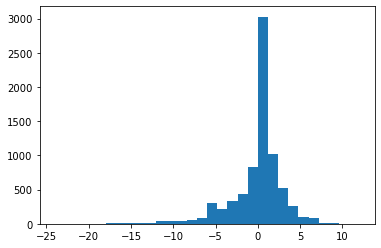

In [83]:
%matplotlib inline
plt.hist(diff_all.np[(spam_vol.np==0) & (diff_all.np != 0)].flatten(), bins=30)

(array([1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 5.000e+00, 4.000e+00,
        6.000e+00, 8.000e+00, 2.800e+01, 2.500e+01, 2.000e+01, 5.000e+01,
        1.630e+02, 1.420e+02, 2.290e+02, 3.430e+02, 4.640e+02, 1.607e+03,
        1.516e+03, 0.000e+00, 3.723e+03, 2.335e+03, 4.640e+02, 1.880e+02,
        1.030e+02, 8.100e+01, 1.700e+01, 1.000e+01, 4.000e+00, 3.000e+00]),
 array([-24.        , -22.76666667, -21.53333333, -20.3       ,
        -19.06666667, -17.83333333, -16.6       , -15.36666667,
        -14.13333333, -12.9       , -11.66666667, -10.43333333,
         -9.2       ,  -7.96666667,  -6.73333333,  -5.5       ,
         -4.26666667,  -3.03333333,  -1.8       ,  -0.56666667,
          0.66666667,   1.9       ,   3.13333333,   4.36666667,
          5.6       ,   6.83333333,   8.06666667,   9.3       ,
         10.53333333,  11.76666667,  13.        ]),
 <BarContainer object of 30 artists>)

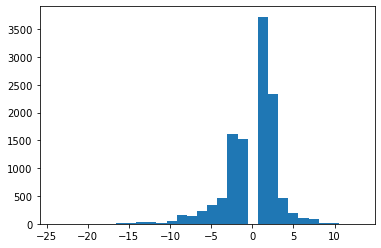

In [84]:
%matplotlib inline
plt.hist(diff_all.np[(spam_vol.np<_threshold_for_spam) & (diff_all.np != 0)].flatten(), bins=30)

In [85]:
print(diff_all.np[(spam_vol.np==0) & (diff_all.np != 0)].flatten().mean())
print(diff_all.np[(spam_vol.np==0) & (diff_all.np != 0)].flatten().std())

0.10625753718343829
3.1240968202640955


In [86]:
print(diff_all.np[(spam_vol.np<_threshold_for_spam) & (diff_all.np != 0)].flatten().mean())
print(diff_all.np[(spam_vol.np<_threshold_for_spam) & (diff_all.np != 0)].flatten().std())

-0.08888503855150308
3.215831979868515


In [87]:
%matplotlib qt5


In [88]:
list_after_cropped[0].shape

(25, 42, 36, 1)

In [89]:
subject_df = pd.DataFrame({"Subject":subject_l})
subject_df.to_csv("/tmp/Rskeleton_subject.csv", index=False)
subject_df.head()

,Subject
0,sub-5809266
1,sub-4192947
2,sub-1851213
3,sub-1755382
4,sub-1743426


In [90]:
list_after_cropped[0].shape

(25, 42, 36, 1)

In [91]:
len(list_after_cropped)

60

In [92]:
after_cropped_npy = np.stack(list_after_cropped, axis=0)
np.save("/tmp/rskeleton.npy", after_cropped_npy)

In [93]:
after_cropped_npy.shape

(60, 25, 42, 36, 1)

In [94]:
len(subject_df)

60